# Preprocessing Data for Model 2

In [1]:
# General initialization
simulation_timeframe = '2019'

In [2]:
# Global parameter initialization
if simulation_timeframe == '2017':
    files_to_combine = ['data2017_raw_model2']
    preprocessed_filename = 'data2017_model2'
    preprocessed_filename_noOpp = 'data2017_model2_noOpp'
    
elif simulation_timeframe == '2018':
    files_to_combine = ['data2018_raw_model2']
    preprocessed_filename = 'data2018_model2'
    preprocessed_filename_noOpp = 'data2018_model2_noOpp'
    
elif simulation_timeframe == '2017-2018':
    files_to_combine = ['data2017_raw_model2', 'data2018_raw_model2']
    preprocessed_filename = 'data2017-2018_model2'
    preprocessed_filename_noOpp = 'data2017-2018_model2_noOpp'
    
elif simulation_timeframe == '2019':
    files_to_combine = ['data2017_raw_model2', 'data2018_raw_model2', 'data2019_raw_model2']
    preprocessed_filename = 'data2019_model2'
    preprocessed_filename_noOpp = 'data2019_model2_noOpp'

## Load libraries and define functions

### 0.1 General python functionality

In [3]:
# Functions
import numpy as np
import os
import pickle
import pandas as pd
import operator
import itertools
from numpy.random import choice
from collections import Counter
import statistics
from datetime import datetime
from scipy import stats

# Functions used for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn import preprocessing

### 0.2 Custom functions

In [5]:
### Function used to return a summary for categorical variables
def SummaryCategoricalVar(list_of_values, title, threshold = 20, top = 10):
    """
    param: list_of_values (list): A list of categorical values from which we like to obtain the distribution
    param: title (string): The title for the visualization
    param: threshold (int): The maximal number of categories that should be visualized
    param: top (int): The top k values that should be returned in the written summary when the number of categories is above the threshold
    """
    # Count the number of occurrances in the list
    cnt = Counter(list_of_values)
    sorted_cnt = sorted(cnt.items(), key=operator.itemgetter(1))[::-1]
    
    # Show the percentage dictionary if to many categories to represent
    print("-"* 100, "\nOverview of variable: ", title, "\n", "-"*100)
    print("Total categories:", len(cnt), "\n")
    if len(cnt) > threshold:
        if len(cnt) < top*2:
            for key, value in sorted_cnt:
                print(key, ':', round(value/len(list_of_values)*100, 4), "%")
        else:
            print("The 10 with the highest percentage data available:\n")
            for key, value in sorted_cnt[:top]:
                print(key, ':', round(value/len(list_of_values)*100, 4), "%")
            print("\nThe 10 with the lowest percentage data available:\n")
            for key, value in sorted_cnt[len(cnt) - top:]:
                print(key, ':', round(value/len(list_of_values)*100, 4), "%")
                
    # Visualization of labelled data distribution
    else:
        plt.barh(range(1, len(sorted_cnt)+1), 
                 list(map(lambda x: (x/len(list_of_values)*100), [score for label, score in sorted_cnt])), 
                 tick_label = list([label for label, score in sorted_cnt]),
                 color = 'cornflowerblue', 
                 edgecolor = 'steelblue')
        plt.ylabel('Label')
        plt.xlabel('Percentage observations in dataset')
        plt.title(title)
        plt.show()    
        plt.savefig('Barplot_' + title + '.png')

In [6]:
### Function used to return a summary for numeric variables
def SummaryNumericVar(list_of_values, title):
    """
    param: list_of_values (list): A list of categorical values from which we like to obtain the distribution
    param: title (string): The title for the visualization
    """
    
    # Title varibale
    print("="* 100, "\nOverview of variable: ", title, "\n", "="*100)

    # An "interface" to matplotlib.axes.Axes.hist() method
    n, bins, patches = plt.hist(x = list_of_values, bins='auto', color= '#0504aa', alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.ylim(top=np.ceil(n.max() / 10) * 10 if n.max() % 10 else n.max() + 10)
    plt.show()
    plt.savefig('Frequency_' + title + '.png')

    # Print summary statistics
    print("-"*20, "\nSummary statistics:\n", "-"*20)
    print("Minimum value:", min(list_of_values))
    print("Mean:", round(statistics.mean(list_of_values), 4))
    print("Standard deviation:", round(statistics.stdev(list_of_values), 4))
    print("Median:", round(statistics.median(list_of_values), 4))
    print("Maximal value:", max(list_of_values))

    # Plot boxplot
    plt.boxplot(list_of_values, 0, 'grey', 0)
    plt.xlabel('Value')
    plt.title(title)
    plt.show()
    plt.savefig('Boxplot_' + title + '.png')

    # Present outliers
    print("-"*20, "\nOutlier detection:\n", "-"*20)
    print("List of outliers:", {round(value,2) for z_score, value in zip(np.abs(stats.zscore(list_of_values)), list_of_values) if z_score > 3})

    # Check for normally distributed
    stats.probplot(list_of_values, dist="norm", plot= plt)
    plt.show()
    plt.savefig('Probabilityplot_' + title + '.png')

    # Statistics to check normality
    print("-"*20, "\nCheck for normal distribution:\n", "-"*20)
    print("Skewedness:", round(stats.skew(list_of_values), 4))
    print("Kurtosis:", round(stats.kurtosis(list_of_values), 4))

In [7]:
### Function used for a boxcox transformation of input features
def feature_transformer(feature, featurename):
    """
    Visualizes the input feature before and after being boxcox transformed. Furthermore the transformed data,
    based on the optimal lambda estimated with the boxcox method is returned in a standardized fashion (zero mean
    and a variance of one)
    """
    # Boxcox transformation
    transformed_feature, optimizer = stats.boxcox(feature)
    standardized_feature, standardized_transformed_feature = preprocessing.scale(feature), preprocessing.scale(transformed_feature)
    # Visualization
    print("Feature: ", featurename)
    plt.figure()
    sns.kdeplot(standardized_feature, shade=True, label=featurename )
    sns.kdeplot(standardized_transformed_feature, shade=True, label= "Transformed " + featurename)
    plt.savefig('Transformed_' + featurename + '.png')
    print("The optimal value for lambda: ", optimizer)
    # Return transformed and standardized data
    return standardized_transformed_feature, optimizer

## 1. Read in data

In [8]:
# Merge the different datasets needed for modelling 
if len(files_to_combine) > 1:
    data_list = []
    for file in files_to_combine:
        with open('/home/je32910/MasterThesis_ComputationalStatistics/pickles/' + file + '.pickle', 'rb') as f:
            data_subset = pickle.load(f)
            data_list.append(data_subset)
    data = pd.concat(data_list)
else:
    with open('/home/je32910/MasterThesis_ComputationalStatistics/pickles/' + files_to_combine[0] + '.pickle', 'rb') as f:
        data = pickle.load(f)

/mgmt/data/conda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [9]:
# Data visuealization
data.head()

,Opp_Player_experience_current_team_adc,Opp_Player_experience_current_team_jungle,Opp_Player_experience_current_team_middle,Opp_Player_experience_current_team_support,Opp_Player_experience_current_team_top,Opp_Player_experience_general_adc,Opp_Player_experience_general_jungle,Opp_Player_experience_general_middle,Opp_Player_experience_general_support,Opp_Player_experience_general_top,...,player_lasso_adc,player_lasso_jungle,player_lasso_middle,player_lasso_support,player_lasso_top,result,result_real,split_ind,team,team_lasso
0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,...,0.726892,0.774323,0.739773,0.554430,0.718721,0.0,1.0,4.0,NaN,0.902008
1,121.0,121.0,121.0,105.0,19.0,121.0,121.0,121.0,105.0,19.0,...,0.732842,0.163171,0.586628,0.759593,0.555703,1.0,0.0,4.0,NaN,0.755135
2,22.0,22.0,13.0,22.0,22.0,22.0,36.0,13.0,22.0,22.0,...,0.773828,0.875533,0.909021,0.852873,0.937070,0.0,1.0,4.0,NaN,0.841262
3,107.0,107.0,107.0,107.0,78.0,107.0,107.0,107.0,107.0,78.0,...,0.525406,0.176077,0.263926,0.514255,0.583942,1.0,0.0,4.0,NaN,0.790924
4,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,...,0.726144,0.392132,0.586628,0.554430,0.582530,1.0,0.0,4.0,NaN,0.540854


## 2. Data transformation and encoding
### Reduce the influence of outliers by applying a box-cox transformation on the data
Because ridge and lasso regression are both sensitive to outlying observations, it was decided to reduce the influence of the latter by applying a box-cox transformation on the numerical features, hence transforming them in a normal shape. We refrained from removing outliers because these could capture relevant information and transformation is assumed to reduce their influence. Different lambda values underlying the exponential transformation of the data are explored [-5, 5] and the optimal value, resulting in the best approximation of the normal curve, is selected.

In [10]:
# Define the columns to exclude
excluded_columns = ['Team', 'Opp_Team']
columns_in_scope = list(set(data.columns) - set(excluded_columns))

Feature:  Player_strategy_middle
The optimal value for lambda:  -8.122457296153105
Feature:  Player_experience_general_middle
The optimal value for lambda:  0.634205133708901
Feature:  Player_experience_current_team_middle
The optimal value for lambda:  0.5139850109418499
Feature:  player_lasso_support
The optimal value for lambda:  1.5756489421089002
Feature:  Player_experience_teamcomposition_adc
The optimal value for lambda:  0.486865193544685
Feature:  Player_strategy_support
The optimal value for lambda:  -3.479669989892234


TypeError: '>' not supported between instances of 'str' and 'int'

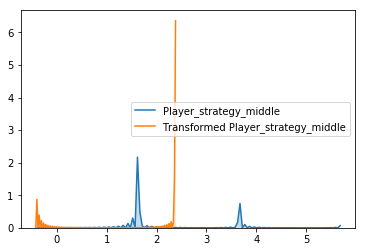

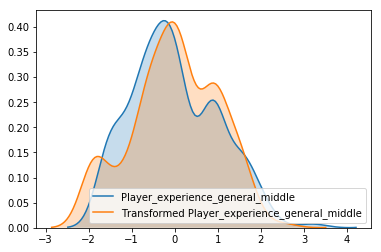

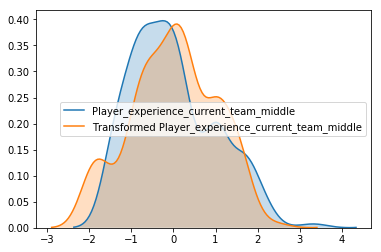

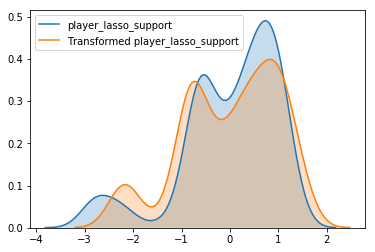

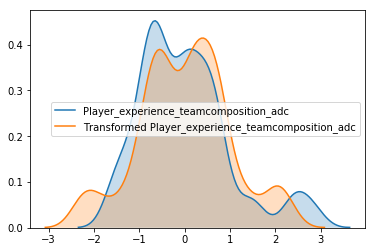

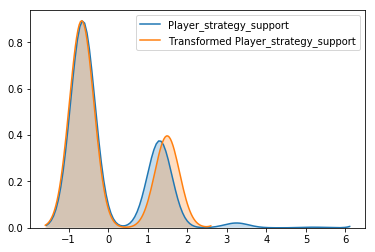

In [11]:
# Initialization
transformed_train_data_df, optimiser_dict = pd.DataFrame(), dict()

# Loop through the data and apply box cox transformation
for num_variable in columns_in_scope:
    if all(data[num_variable] > 0) and num_variable != 'result' and num_variable != 'result_real':
        transformed_feature, optimiser = feature_transformer(data[num_variable], num_variable)
        if -5 <= optimiser <= 5:
            transformed_train_data_df[num_variable] = transformed_feature
            optimiser_dict[num_variable] = optimiser
        else:
            transformed_train_data_df[num_variable] = preprocessing.scale(data[num_variable])
            optimiser_dict[num_variable] = np.nan
    else:
        transformed_train_data_df[num_variable] = preprocessing.scale(data[num_variable])
        
# Add result feature
transformed_train_data_df = transformed_train_data_df.drop(labels = ['result', 'result_real'], axis=1)
transformed_train_data_df['result_real'] = list(data['result_real'])
transformed_train_data_df['result'] = list(data['result'])
transformed_train_data_df['Team'] = list(data['Team'])
transformed_train_data_df['Opp_Team'] = list(data['Opp_Team'])

In [ ]:
# Loop through all numerical variables and visualize data
for num_variable in columns_in_scope:
    SummaryNumericVar(transformed_train_data_df[num_variable], num_variable)

## 3. Write transformed away
Data ready for use in model 2 is written away for modelling in the next phase

In [ ]:
# Write data away in pickle
with open('/home/je32910/MasterThesis_ComputationalStatistics/pickles/' + preprocessed_filename + '.pickle', 'wb') as f:
    pickle.dump(transformed_train_data_df, f)

In [ ]:
# Write data away in pickle (with the information of the opponent removed)
opp_columns_to_drop = [col for col in transformed_train_data_df.columns if 'Opp' in col]
transformed_train_data_df_noOpp = transformed_train_data_df.drop(opp_columns_to_drop, axis=1)
transformed_train_data_df_noOpp = transformed_train_data_df_noOpp.drop_duplicates()
with open('/home/je32910/MasterThesis_ComputationalStatistics/pickles/' + preprocessed_filename_noOpp + '.pickle', 'wb') as f:
    pickle.dump(transformed_train_data_df_noOpp, f)